In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import randint, sample
from scipy.linalg import subspace_angles
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
%matplotlib inline

In [2]:
WS_LOC = '../../data/subspaces/goi5k/'

In [30]:
def get_subspace(folder: str = WS_LOC, index = None) -> np.ndarray:
    npy_subspaces = os.listdir(WS_LOC)
    if index is None:
        index = randint(0, len(npy_subspaces))
    S = np.load(os.path.join(WS_LOC, npy_subspaces[index]))
    return S

def sample_subspaces(folder: str = WS_LOC, count: int = 10) -> tuple:
    sample_subs = sample(population=os.listdir(WS_LOC),k=count)
    ids = [sub.split('.')[0] for sub in sample_subs]
    return ids, np.asarray([np.load(os.path.join(WS_LOC, sub)) for sub in sample_subs], dtype=np.float32)
#     return [np.load(os.path.join(WS_LOC, sub)) for sub in sample_subs]

def subspaces_similarity(S1, S2):
    canon_angles = subspace_angles(S1, S2)
    return np.average(np.square(np.cos(canon_angles)))

In [31]:
sub_one = get_subspace()
sub_two = get_subspace()
sim = subspaces_similarity(S1=sub_one, S2=sub_two)

## Compute the condensed distance matrix

#### Distance Function:
    D(x, y) = 1 - S(x, y), where 0 <= S <= 1

In [32]:
def condensed_dist(subs):
    n = subs.shape[0]
    dm = []
    for i in range(n):
        s_i = subs[i]
        dm.extend([1 - subspaces_similarity(S1=s_i, S2=subs[j]) for j in range(i+1, n)])
    return np.array(dm)

## Scipy Dendrogram

https://www.analyticsvidhya.com/blog/2019/05/beginners-guide-hierarchical-clustering/

In [67]:
count = 10
labels = range(0, count)
ids, subs = sample_subspaces(count=count)
dm = condensed_dist(subs)

In [68]:
linked = linkage(y=dm, method='complete')
linked

array([[ 1.        ,  4.        ,  0.8453529 ,  2.        ],
       [ 2.        ,  5.        ,  0.8795258 ,  2.        ],
       [ 0.        ,  7.        ,  0.90210769,  2.        ],
       [ 3.        , 10.        ,  0.9086639 ,  3.        ],
       [ 9.        , 13.        ,  0.92444195,  4.        ],
       [ 6.        , 12.        ,  0.94245781,  3.        ],
       [ 8.        , 11.        ,  0.95169339,  3.        ],
       [14.        , 15.        ,  0.96995418,  7.        ],
       [16.        , 17.        ,  0.97554091, 10.        ]])

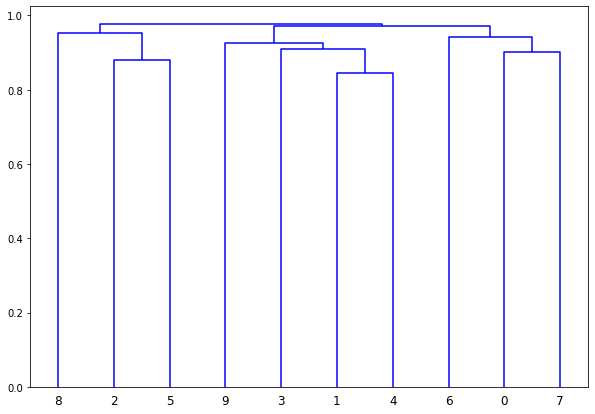

In [69]:
plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=labels,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

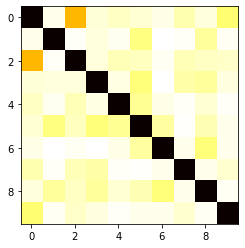

In [42]:
s_dm = squareform(dm)
plt.imshow(s_dm, cmap='hot', interpolation='nearest')
plt.show()

## Clustering

In [171]:
class Cluster:
    
    def __init__(self, label: int, subspace, sub_id: str):
        self.label = label
        self.size = 1
        self.subspaces = np.expand_dims(subspace, axis=0)
        self.rep = subspace
        self.ids = [sub_id]
    
    def __repr__(self):
        return f'Cluster-{self.label}'
    
    def __lt__(self, other):
        return True
    
    def __eq__(self, other):
        return True
    
    def distance(self, other):
        # other is subspace (300, 5)
        return 1 - subspaces_similarity(S1=self.rep, S2=other)
    
    def add(self, subspace, sub_id: str):
        self.subspaces = np.append(self.subspaces, np.expand_dims(subspace, axis=0), axis=0)
        self.size += 1
        self.compute_rep()
        self.ids.append(sub_id)
        
    def compute_rep(self):
        self.rep = np.mean(self.subspaces, axis=0, dtype=np.float64)
    
    def get_rep(self):
        return self.rep

class Index:
    
    def __init__(self, subspaces: np.ndarray):
        pass

In [172]:
def pdist_heatmap(subspaces):
    dm = condensed_dist(subspaces)
    s_dm = squareform(dm)
    plt.imshow(s_dm, cmap='hot', interpolation='nearest')
    plt.show()

In [240]:
def get_labels(subspaces) -> list:
    dm = condensed_dist(subs)
    s_dm = squareform(dm)
    
    n_clusters = int(np.sqrt(len(subspaces)))
    affinity = 'precomputed'
    lnkg = 'complete' # single or complete
    compute_full_tree = 'auto'
    if n_clusters is not None:
        distance_threshold = None
    else:
        distance_threshold = 0.85
    ac = AgglomerativeClustering(n_clusters=n_clusters, 
                                 affinity=affinity, 
                                 linkage=lnkg,
                                 compute_full_tree=compute_full_tree, 
                                 distance_threshold=distance_threshold)
    ac.fit(s_dm)
    print(f'Number of clusters: {ac.n_clusters_}')
    return ac.labels_

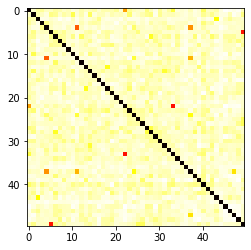

In [263]:
count = 50
ids, subs = sample_subspaces(count=count)
pdist_heatmap(subspaces=subs)

In [264]:
labels = get_labels(subspaces=subs)
labels

Number of clusters: 7


array([3, 0, 0, 5, 2, 4, 1, 4, 0, 3, 0, 2, 6, 4, 2, 3, 5, 1, 4, 0, 2, 5,
       3, 0, 2, 4, 3, 5, 1, 4, 6, 2, 5, 3, 5, 0, 1, 2, 1, 3, 5, 0, 2, 0,
       5, 6, 0, 2, 4, 4])

In [265]:
from collections import Counter
Counter(labels)

Counter({3: 7, 0: 10, 5: 8, 2: 9, 4: 8, 1: 5, 6: 3})

### Create clusters

In [266]:
clusters = {}
for i, s, l in zip(ids, subs, labels):
    if l not in clusters:
        clusters[l] = Cluster(label=l, subspace=s, sub_id=i)
    else:
        clusters[l].add(subspace=s, sub_id=i)

In [267]:
clusters[0].distance(subs[0])

0.8910743303722247

In [124]:
import sys
sys.path.append("/home/zhanibek/Desktop/Fall '19/Senior Project/news2image")
from gensim.models import KeyedVectors
from src.common.space import Space
from src.text.encoder import TextEncoder
from src.config import Word2VecConfig, ImageConfig

t_keyed_vectors = KeyedVectors.load_word2vec_format(fname=Word2VecConfig.get_word_vectors_filename(),
                                                        limit=Word2VecConfig.get_vocab_size(),
                                                        binary=True)
space = Space(keyed_vectors=t_keyed_vectors)
text_encoder = TextEncoder(space=space)

def get_random_text() -> str:
   # Get a random text
    texts_folder = "/home/zhanibek/Desktop/Fall '19/Senior Project/news2image/data/texts"
    category = 'news'
    txts = os.listdir(os.path.join(texts_folder, category))
    r = randint(0, len(txts))
    with open(os.path.join(texts_folder, category, txts[r]), 'r') as f:
        t_text = f.read()
    return t_text 

2020-04-21 11:44:22,193 gensim.models.utils_any2vec: INFO loading projection weights from ~/Downloads/GoogleNews-vectors-negative300.bin.gz
2020-04-21 11:44:22,958 gensim.models.utils_any2vec: INFO loaded (20000, 300) matrix from ~/Downloads/GoogleNews-vectors-negative300.bin.gz


In [298]:
full_text1 = get_random_text()
print(full_text1)
sub_txt = text_encoder.create_subspace(text=full_text1)

 Police had been monitoring a Brazilian gang for three months before making a shocking discovery of an almost 500-metre-long tunnel. The police arrested 16 suspects before they could pull off the robbery of a branch of Banco do Brasil in Sao Paolo. The gang members allegedly told the police that they were planning to steal the equivalent of $317 million, far exceeding the building costs of $1.27 million of the tunnel built from a nearby rented home. More than ten years ago, a different gang in Brazil tunnelled into a bank vault and stole $70 million.


In [299]:
for label, cluster in clusters.items():
    d = cluster.distance(sub_txt)
    print(f'Distance to {cluster} is {d}')

Distance to Cluster-3 is 0.9746350993081186
Distance to Cluster-0 is 0.9613340921774335
Distance to Cluster-5 is 0.9116203145738662
Distance to Cluster-2 is 0.9142414443627558
Distance to Cluster-4 is 0.9214537383778421
Distance to Cluster-1 is 0.9670101993954648
Distance to Cluster-6 is 0.8866760417759966


In [289]:
from IPython.display import Image as ImageOpener, display
images_folder = "/home/zhanibek/Desktop/Fall '19/Senior Project/news2image/data/images/goi5k"
def display_all_images(image_ids: list):
    for image_id in image_ids:
        image_name = os.path.join(images_folder, f'{image_id}.jpg')
        display(ImageOpener(image_name))

In [296]:
i = 2
# display_all_images(clusters[i].ids)

## Searching for an approximate nearest neighbour

In [21]:
a = np.random.rand(2, 3)
b = np.random.rand(2, 3)
print(a)
print(b)

[[0.84569634 0.84222532 0.13376251]
 [0.89899966 0.33340296 0.71435069]]
[[0.61785766 0.27817323 0.25958679]
 [0.99389378 0.40930107 0.04043242]]


In [22]:
cluster = Cluster(subspace=a)
rep = cluster.get_rep()
print(f'Rep:\n{rep}')
# cluster.add(a)
cluster.add(b)
rep = cluster.get_rep()
print(f'Rep:\n{rep}')

cluster.subspaces

Rep:
[[0.84569634 0.84222532 0.13376251]
 [0.89899966 0.33340296 0.71435069]]
Rep:
[[0.731777   0.56019928 0.19667465]
 [0.94644672 0.37135202 0.37739156]]


array([[[0.84569634, 0.84222532, 0.13376251],
        [0.89899966, 0.33340296, 0.71435069]],

       [[0.61785766, 0.27817323, 0.25958679],
        [0.99389378, 0.40930107, 0.04043242]]])